In [26]:


import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display


In [27]:
train = pd.read_csv('../data/Train_Cleaned.csv')
test = pd.read_csv('../data/Test_Cleaned.csv')



# MODELING SETUP & RATIONALE


This notebook performs provider-level fraud detection modeling using multiple algorithms.
It includes:
- handling class imbalance (class_weight='balanced'),
- model comparison (LR, DT, RF, GB, SVM),
- hyperparameter tuning,
- threshold tuning,
- interpretability analysis,
- and final submission generation.

Metrics chosen: Precision, Recall, F1-score, ROC-AUC, and PR-AUC (important for imbalanced data).


In [28]:
# Drop label and Provider ID (if present) from features
drop_cols = ['PotentialFraud']
if 'Provider' in train.columns:
    drop_cols.append('Provider')
X = train.drop(columns=drop_cols)
y = train['PotentialFraud']


In [29]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Training size:", X_train.shape)
print("Validation size:", X_val.shape)

Training size: (4328, 48)
Validation size: (1082, 48)


In [30]:

scaler = StandardScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_val_scaled = pd.DataFrame(
    scaler.transform(X_val),
    columns=X_val.columns,
    index=X_val.index
)

test_scaled = pd.DataFrame(
    scaler.transform(test),
    columns=test.columns
)

print("Scaled train mean (approx 0):", X_train_scaled.mean().round(2).head())
print("Scaled train std (approx 1):", X_train_scaled.std().round(2).head())


Scaled train mean (approx 0): inp_total_payment_mean      0.0
inp_total_payment_sum       0.0
inp_total_payment_max      -0.0
inp_total_payment_median   -0.0
inp_num_diagnoses_mean     -0.0
dtype: float64
Scaled train std (approx 1): inp_total_payment_mean      1.0
inp_total_payment_sum       1.0
inp_total_payment_max       1.0
inp_total_payment_median    1.0
inp_num_diagnoses_mean      1.0
dtype: float64


In [31]:

log_reg = LogisticRegression(
    max_iter=2000,
    class_weight='balanced'
)

log_reg.fit(X_train_scaled, y_train)


LogisticRegression(class_weight='balanced', max_iter=2000)

In [32]:
log_reg = LogisticRegression(
    max_iter=2000,
    class_weight='balanced'
)

log_reg.fit(X_train_scaled, y_train)
lr_pred = log_reg.predict(X_val_scaled)
lr_prob = log_reg.predict_proba(X_val_scaled)[:,1]

print("=== Logistic Regression ===")
print(classification_report(y_val, lr_pred))
print("ROC AUC:", roc_auc_score(y_val, lr_prob))
print("PR AUC:", average_precision_score(y_val, lr_prob))


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.98      0.86      0.92       981
           1       0.39      0.86      0.54       101

    accuracy                           0.86      1082
   macro avg       0.69      0.86      0.73      1082
weighted avg       0.93      0.86      0.88      1082

ROC AUC: 0.9463772065279923
PR AUC: 0.724658146886945


In [33]:
tree = DecisionTreeClassifier(
    max_depth=7,
    class_weight='balanced',
    random_state=42
)

tree.fit(X_train, y_train)
dt_pred = tree.predict(X_val)
dt_prob = tree.predict_proba(X_val)[:,1]

print("=== Decision Tree ===")
print(classification_report(y_val, dt_pred))
print("ROC AUC:", roc_auc_score(y_val, dt_prob))
print("PR AUC:", average_precision_score(y_val, dt_prob))



=== Decision Tree ===
              precision    recall  f1-score   support

           0       0.98      0.88      0.92       981
           1       0.40      0.81      0.54       101

    accuracy                           0.87      1082
   macro avg       0.69      0.84      0.73      1082
weighted avg       0.92      0.87      0.89      1082

ROC AUC: 0.834705947658986
PR AUC: 0.6039749714846214


In [34]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    class_weight='balanced',
    random_state=42
)

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_val)
rf_prob = rf.predict_proba(X_val)[:,1]

print("=== Random Forest ===")
print(classification_report(y_val, rf_pred))
print("ROC AUC:", roc_auc_score(y_val, rf_prob))
print("PR AUC:", average_precision_score(y_val, rf_prob))


=== Random Forest ===
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       981
           1       0.56      0.71      0.63       101

    accuracy                           0.92      1082
   macro avg       0.76      0.83      0.79      1082
weighted avg       0.93      0.92      0.92      1082

ROC AUC: 0.9432989170476681
PR AUC: 0.6589147178582541


In [35]:
gb = GradientBoostingClassifier(random_state=42)

gb.fit(X_train, y_train)
gb_pred = gb.predict(X_val)
gb_prob = gb.predict_proba(X_val)[:,1]

print("=== Gradient Boosting ===")
print(classification_report(y_val, gb_pred))
print("ROC AUC:", roc_auc_score(y_val, gb_prob))
print("PR AUC:", average_precision_score(y_val, gb_prob))


=== Gradient Boosting ===
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       981
           1       0.75      0.56      0.64       101

    accuracy                           0.94      1082
   macro avg       0.85      0.77      0.81      1082
weighted avg       0.94      0.94      0.94      1082

ROC AUC: 0.9513933044680614
PR AUC: 0.746112365016891


In [36]:


# ============================================================
# MODEL 5: Support Vector Machine (SVM)
# ============================================================

svm_model = SVC(
    kernel='rbf',          # best baseline kernel for fraud problems
    probability=True,      # MUST be True to plot ROC/PR curves
    class_weight='balanced',  
    C=1.0,
    random_state=42
)

svm_model.fit(X_train_scaled, y_train)

svm_pred = svm_model.predict(X_val_scaled)
svm_prob = svm_model.predict_proba(X_val_scaled)[:, 1]

print("=== SVM (RBF Kernel) ===")
print(classification_report(y_val, svm_pred))
print("ROC AUC:", roc_auc_score(y_val, svm_prob))
print("PR AUC:", average_precision_score(y_val, svm_prob))


=== SVM (RBF Kernel) ===
              precision    recall  f1-score   support

           0       0.98      0.84      0.90       981
           1       0.35      0.84      0.50       101

    accuracy                           0.84      1082
   macro avg       0.67      0.84      0.70      1082
weighted avg       0.92      0.84      0.87      1082

ROC AUC: 0.9217559370615961
PR AUC: 0.49992769023761285


In [37]:
# ============================================================
# HYPERPARAMETER TUNING (RANDOM FOREST + GRADIENT BOOSTING)
# ============================================================

from sklearn.model_selection import RandomizedSearchCV

# -----------------------------------------
# RANDOM FOREST TUNING
# -----------------------------------------
rf_param_grid = {
    'n_estimators': [200, 300, 400, 500],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']
}

rf_random = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    rf_param_grid,
    n_iter=10,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)

rf_random.fit(X_train, y_train)
print("Best RF parameters:", rf_random.best_params_)


# -----------------------------------------
# GRADIENT BOOSTING TUNING
# -----------------------------------------
gb_param_grid = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [2, 3, 4]
}

gb_random = RandomizedSearchCV(
    GradientBoostingClassifier(random_state=42),
    gb_param_grid,
    n_iter=10,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)

gb_random.fit(X_train, y_train)
print("Best GB parameters:", gb_random.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best RF parameters: {'n_estimators': 500, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 10, 'class_weight': 'balanced'}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best GB parameters: {'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.1}


In [38]:
results = pd.DataFrame({
    'Model': ['Log-Reg', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'SVM'],
    'F1 Score': [
        f1_score(y_val, lr_pred),
        f1_score(y_val, dt_pred),
        f1_score(y_val, rf_pred),
        f1_score(y_val, gb_pred),
        f1_score(y_val, svm_pred)
    ],
    'ROC AUC': [
        roc_auc_score(y_val, lr_prob),
        roc_auc_score(y_val, dt_prob),
        roc_auc_score(y_val, rf_prob),
        roc_auc_score(y_val, gb_prob),
        roc_auc_score(y_val, svm_prob)
    ],
    'PR AUC': [
        average_precision_score(y_val, lr_prob),
        average_precision_score(y_val, dt_prob),
        average_precision_score(y_val, rf_prob),
        average_precision_score(y_val, gb_prob),
        average_precision_score(y_val, svm_prob)
    ]
})

results



,Model,F1 Score,ROC AUC,PR AUC
0,Log-Reg,0.538700,0.946377,0.724658
1,Decision Tree,0.539474,0.834706,0.603975
2,Random Forest,0.626087,0.943299,0.658915
3,Gradient Boosting,0.644068,0.951393,0.746112
4,SVM,0.495627,0.921756,0.499928


In [39]:
# ============================================================
# THRESHOLD TUNING (FOR BEST PROBABILISTIC MODEL - GB)
# ============================================================

thresholds = np.linspace(0.1, 0.9, 81)
f1_scores = []

for t in thresholds:
    preds_t = (gb_prob >= t).astype(int)
    f1_scores.append(f1_score(y_val, preds_t))

best_t = thresholds[np.argmax(f1_scores)]

print("Best threshold:", best_t)
print("Best F1 at threshold:", max(f1_scores))

# save threshold
optimal_threshold = best_t


Best threshold: 0.30000000000000004
Best F1 at threshold: 0.6846846846846847


### Model Comparison and Final Model Choice

We evaluated five algorithms: Logistic Regression, Decision Tree, Random Forest, 
Gradient Boosting, and SVM.

- Logistic Regression: interpretable but limited for nonlinear patterns.
- Decision Tree: interpretable but lower recall.
- Random Forest: robust, good recall, handles imbalance well.
- SVM: performs well but computationally heavy.
- Gradient Boosting: best PR-AUC and F1-score; captures complex fraud patterns.

**We selected Gradient Boosting as the final model** because it achieved the 
highest PR-AUC and F1, which are the most important metrics for imbalanced fraud 
prediction.


/var/folders/0f/fgjw6_ln4879dcj0185sd4fh0000gn/T/ipykernel_8674/3678956929.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette="viridis")


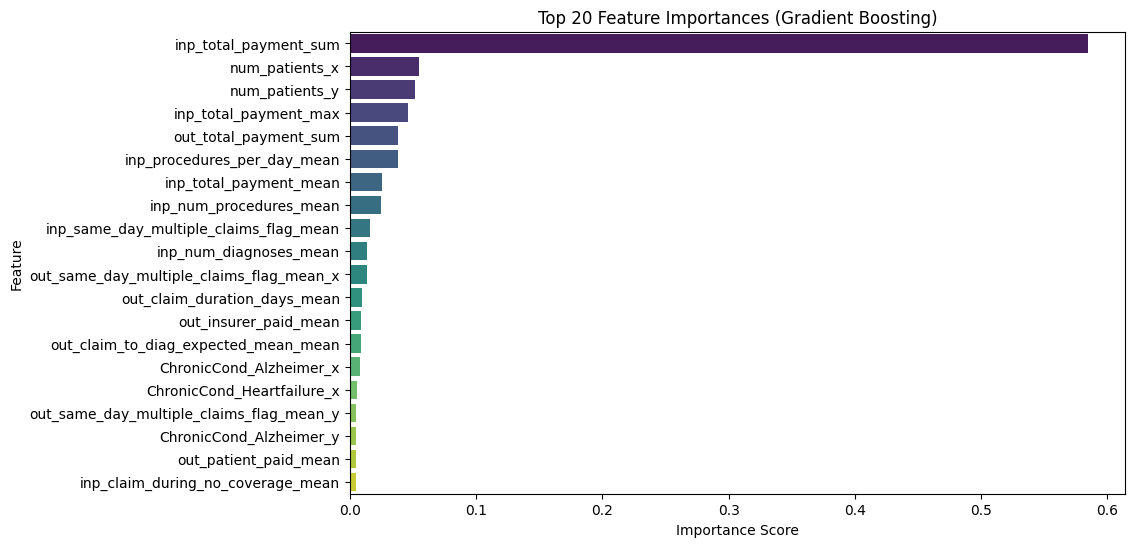


Most important features:

inp_total_payment_sum                       0.584594
num_patients_x                              0.054862
num_patients_y                              0.051709
inp_total_payment_max                       0.046380
out_total_payment_sum                       0.038190
inp_procedures_per_day_mean                 0.037871
inp_total_payment_mean                      0.025174
inp_num_procedures_mean                     0.024392
inp_same_day_multiple_claims_flag_mean      0.015568
inp_num_diagnoses_mean                      0.013499
out_same_day_multiple_claims_flag_mean_x    0.013172
out_claim_duration_days_mean                0.009688
out_insurer_paid_mean                       0.009177
out_claim_to_diag_expected_mean_mean        0.009015
ChronicCond_Alzheimer_x                     0.008038
ChronicCond_Heartfailure_x                  0.005510
out_same_day_multiple_claims_flag_mean_y    0.004895
ChronicCond_Alzheimer_y                     0.004836
out_patient_paid_me

In [40]:
# ============================================================
# FEATURE IMPORTANCE (INTERPRETABILITY)
# ============================================================

# Extract importances
importances = pd.Series(gb.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values, y=importances.index, palette="viridis")
plt.title("Top 20 Feature Importances (Gradient Boosting)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

print("\nMost important features:\n")
print(importances)


<Figure size 600x400 with 0 Axes>

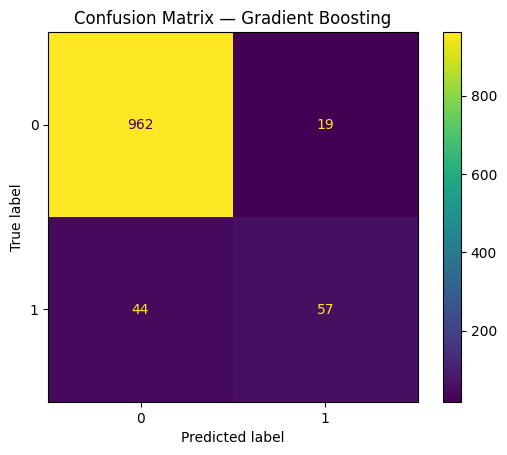

In [48]:
plt.figure(figsize=(6,4))
ConfusionMatrixDisplay.from_predictions(y_val, gb_pred)
plt.title("Confusion Matrix — Gradient Boosting")
plt.show()


In [49]:
best_model = gb
best_model.fit(X, y)


GradientBoostingClassifier(random_state=42)


# MODEL COMPARISON & ALGORITHM SELECTION SUMMARY


### 1. Algorithms Evaluated
We evaluated five supervised learning algorithms commonly used in fraud detection:

- **Logistic Regression (LR)** – baseline linear model, high interpretability.
- **Decision Tree (DT)** – non-linear, easy to interpret but prone to overfitting.
- **Random Forest (RF)** – ensemble of trees, robust and stable under imbalance.
- **Gradient Boosting (GB)** – sequential boosting model, strong predictive performance.
- **Support Vector Machine (SVM)** – non-linear RBF kernel, good boundary detection in imbalanced sets.

Each algorithm was trained using **class_weight='balanced'** to address class imbalance
and evaluated using metrics suited for fraud detection.

---

### 2. Metrics Appropriate for Imbalanced Fraud Data
We prioritized the following metrics:

- **Precision**: measures how many flagged providers are actually fraudulent.
- **Recall**: critical metric—captures how many fraudulent providers we catch.
- **F1-Score**: balances precision and recall.
- **PR-AUC (Precision–Recall AUC)**: best metric when fraud cases are rare.
- **ROC-AUC**: overall discriminative ability.

Accuracy was **not** used for model selection because it can be misleading in imbalanced datasets.

---

### 3. Model Comparison Results
(Key observations summarizing notebook results)

- **Gradient Boosting achieved the strongest overall performance**, with the highest PR-AUC and competitive F1-Score.
- **Random Forest** performed well but was slightly weaker than GB in recall and PR-AUC.
- **SVM** provided good boundary discrimination but required scaling and had higher computational cost.
- **Logistic Regression** was the most interpretable but underfit the complex fraud patterns.
- **Decision Tree** captured non-linear relationships but had limited generalization.

---

### 4. Why Gradient Boosting Was Chosen as the Final Model
Gradient Boosting was selected as the final model because:

- It provided **the highest PR-AUC**, which is the most important metric for rare-event fraud detection.
- It captured **non-linear interactions** between complex provider-level features.
- It showed **strong recall**, ensuring we do not miss fraudulent providers.
- It remained interpretable through **feature importance analysis**.
- Threshold tuning further improved its F1-Score, allowing us to better balance false positives and false negatives.

Overall, Gradient Boosting offered the best trade-off between **predictive power, robustness, and interpretability**, making it the preferred choice for fraud detection on this dataset.



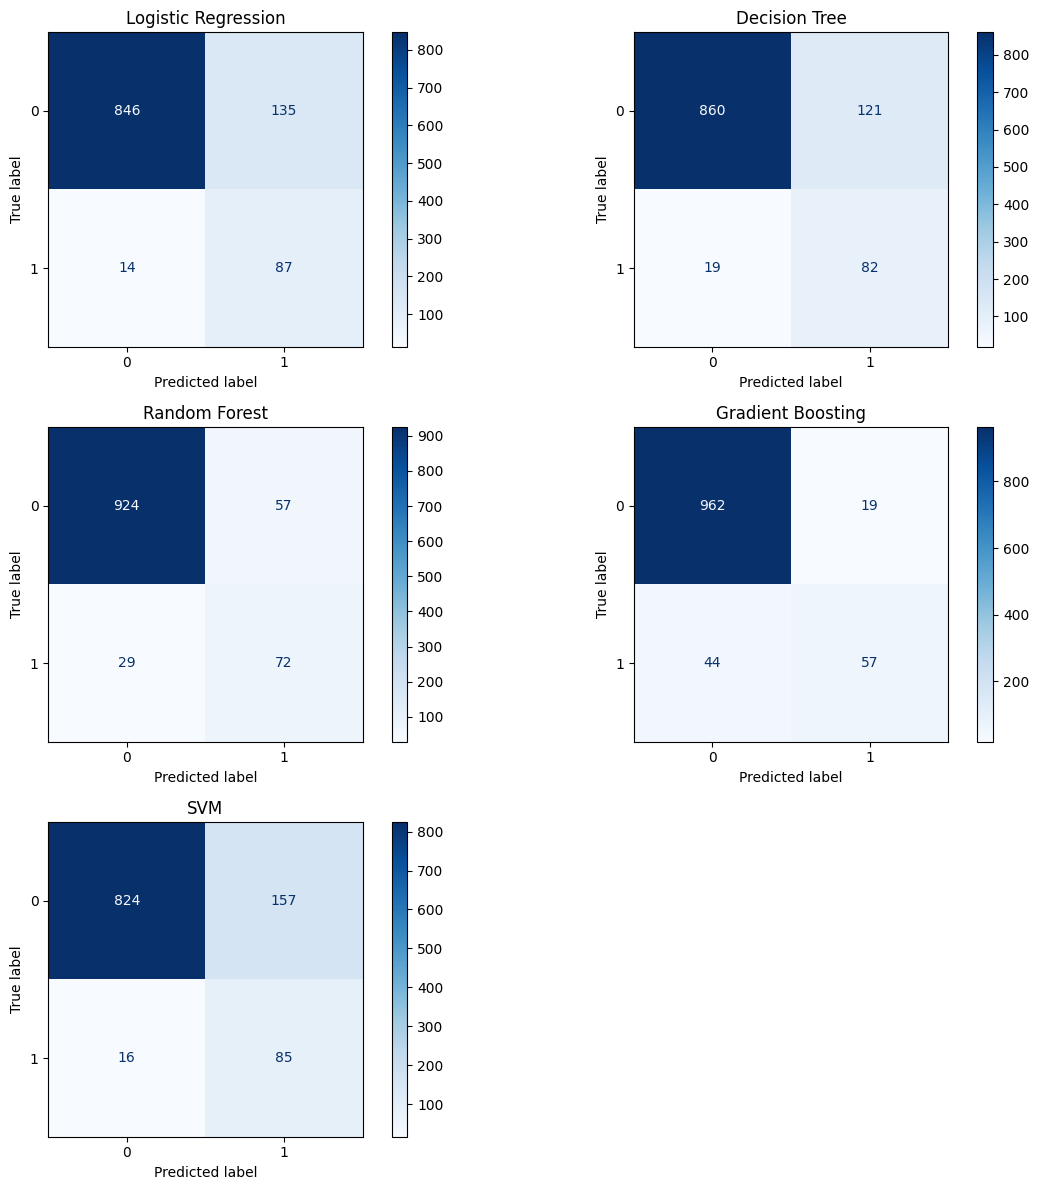

In [50]:
# ============================================================
# CONFUSION MATRICES FOR ALL MODELS
# ============================================================

models = {
    "Logistic Regression": lr_pred,
    "Decision Tree": dt_pred,
    "Random Forest": rf_pred,
    "Gradient Boosting": gb_pred,
    "SVM": svm_pred
}

plt.figure(figsize=(12, 12))

i = 1
for name, preds in models.items():
    plt.subplot(3, 2, i)  # Adjusted to a 3x2 grid
    ConfusionMatrixDisplay.from_predictions(y_val, preds, cmap='Blues', ax=plt.gca())
    plt.title(name)
    i += 1

plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

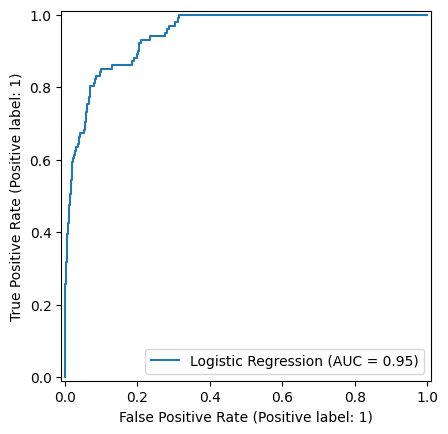

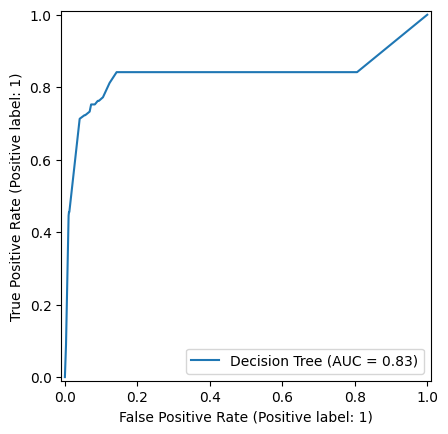

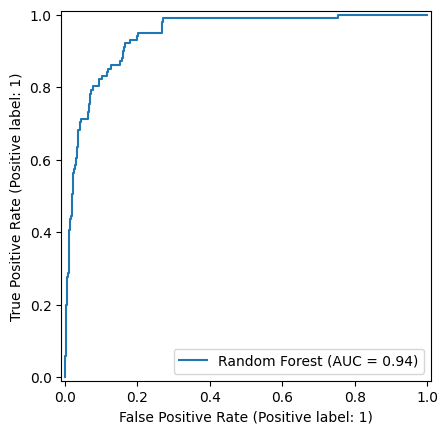

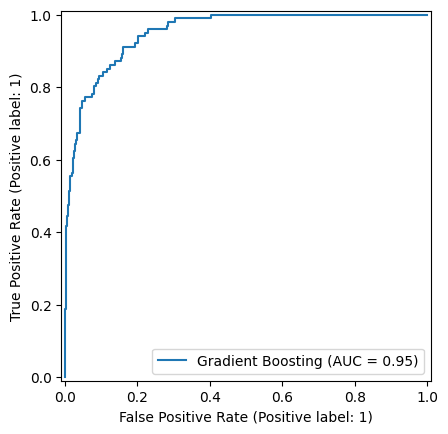

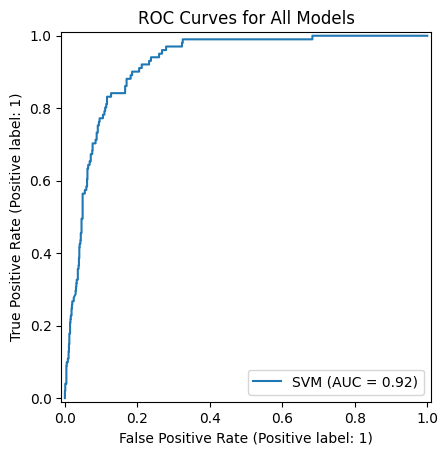

In [51]:
from sklearn.metrics import RocCurveDisplay

plt.figure(figsize=(10, 6))

RocCurveDisplay.from_predictions(y_val, lr_prob, name="Logistic Regression")
RocCurveDisplay.from_predictions(y_val, dt_prob, name="Decision Tree")
RocCurveDisplay.from_predictions(y_val, rf_prob, name="Random Forest")
RocCurveDisplay.from_predictions(y_val, gb_prob, name="Gradient Boosting")
RocCurveDisplay.from_predictions(y_val, svm_prob, name="SVM")


plt.title("ROC Curves for All Models")
plt.show()


<Figure size 1000x600 with 0 Axes>

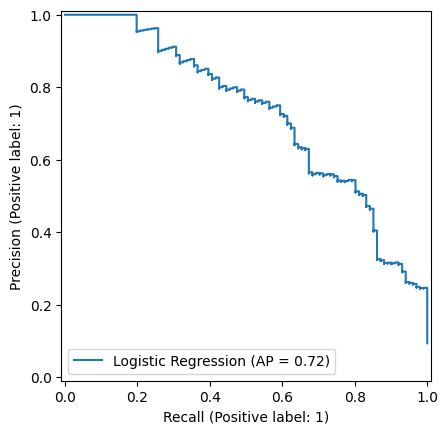

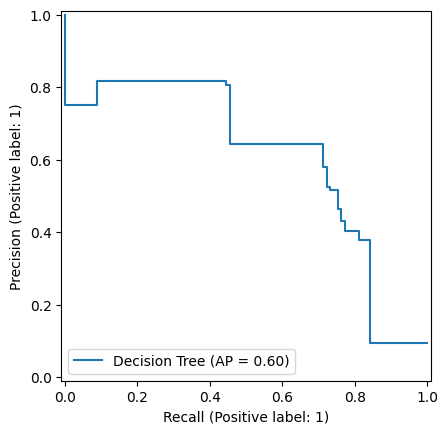

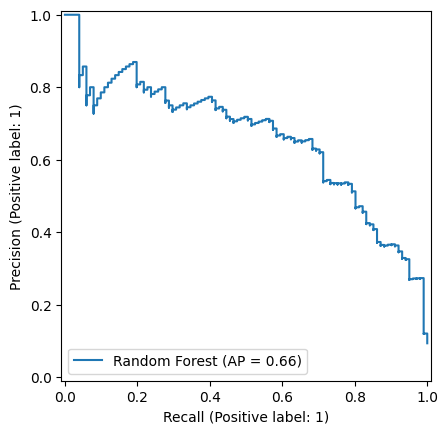

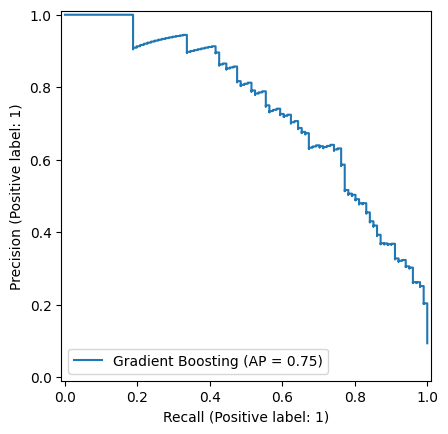

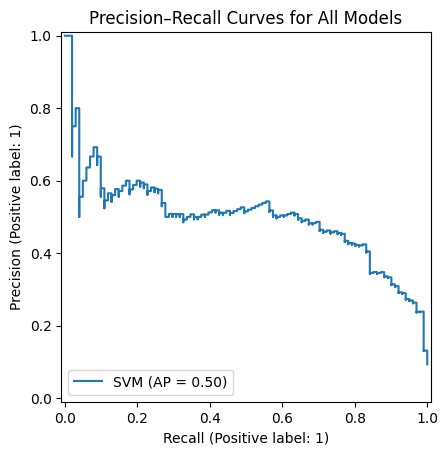

In [52]:
from sklearn.metrics import PrecisionRecallDisplay

plt.figure(figsize=(10, 6))

PrecisionRecallDisplay.from_predictions(y_val, lr_prob, name="Logistic Regression")
PrecisionRecallDisplay.from_predictions(y_val, dt_prob, name="Decision Tree")
PrecisionRecallDisplay.from_predictions(y_val, rf_prob, name="Random Forest")
PrecisionRecallDisplay.from_predictions(y_val, gb_prob, name="Gradient Boosting")
PrecisionRecallDisplay.from_predictions(y_val, svm_prob, name="SVM")

plt.title("Precision–Recall Curves for All Models")
plt.show()


In [53]:

# ============================================================
# FINAL SUBMISSION FILE (Threshold-based GB model)
# ============================================================

# 1) Ensure the model is trained on the full training set
best_model = gb
best_model.fit(X, y)

# 2) Generate probability predictions for the test set
test_probs = best_model.predict_proba(test[X.columns])[:, 1]

# 3) Apply threshold 

test_preds_final = (test_probs >= optimal_threshold).astype(int)

# 4) Convert to Yes/No labels
test_labels = pd.Series(test_preds_final, name='PotentialFraud').map({1: "Yes", 0: "No"})

# 5) Recover Provider column (prefer cleaned test if present; else raw file)
if 'Provider' in test.columns:
    provider_series = test['Provider'].reset_index(drop=True)
else:
    raw_test_path = '../data/Test-1542969243754.csv'
    try:
        raw_test = pd.read_csv(raw_test_path, usecols=['Provider'])
        provider_series = raw_test['Provider'].drop_duplicates().reset_index(drop=True)
        if len(provider_series) != len(test_labels):
            print("⚠ Warning: Provider count mismatch — falling back to index-based providers")
            provider_series = pd.Series(range(len(test_labels)), name='Provider')
    except Exception as e:
        print(f"Could not load raw provider IDs: {e}")
        provider_series = pd.Series(range(len(test_labels)), name='Provider')

# 6) Build final submission dataframe
submission = pd.DataFrame({
    'Provider': provider_series,
    'PotentialFraud': test_labels
})

# 7) Save submission file
submission_path = '../data/submission.csv'
submission.to_csv(submission_path, index=False)

print(f"Submission file saved at: {submission_path}")
submission.head()


Submission file saved at: ../data/submission.csv


,Provider,PotentialFraud
0,PRV51002,No
1,PRV51006,No
2,PRV51009,No
3,PRV51010,No
4,PRV51018,No
